# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Признаки** 
>- **RowNumber**  — индекс строки в данных
>- **CustomerId**  — уникальный идентификатор клиента
>- **Surname**  — фамилия
>- **CreditScore**  — кредитный рейтинг
>- **Geography**  — страна проживания
>- **Gender**  — пол
>- **Age**  — возраст
>- **Tenure**  — количество недвижимости у клиента
>- **Balance**  — баланс на счёте
>- **NumOfProducts**  — количество продуктов банка, используемых клиентом
>- **HasCrCard**  — наличие кредитной карты
>- **IsActiveMember**  — активность клиента
>- **EstimatedSalary**  — предполагаемая зарплата

**Целевой признак**
>- **Exited**  — факт ухода клиента

## Подготовка данных

Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import roc_curve 


Отключим предупреждения:

In [2]:
pd.options.mode.chained_assignment = None

Прочитаем файл "Churn.csv" и сохраним его в переменной "data":

In [3]:
data = pd.read_csv('/datasets/Churn.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [6]:
data['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

Т.к. клиенты из стран Франции, Германии и Испании, то, скорее всего, все денежные суммы указаны в евро.

Исходя из данных на сайте Kaggle, признак Surname включает в себя 2932 уникальных значений.

Проверим клиентов на уникальность:

In [7]:
len(data['CustomerId'].unique())

10000

Признак Tenure имеет тип данных float64. При чтении файла библиотека вывела этот тип из-за наличия пропусков, которые составляют примерно 10%. Если мы заполним пропуски средним значением, то это может привести к переобучению модели. 

Данных у нас не так уж и мало, поэтому избавимся от пропусков и приведем признак к целочисленному типу:

In [8]:
data.dropna(subset = ['Tenure'], inplace = True)
data['Tenure'] = data['Tenure'].astype('int')

Построим гистограмму баланса:

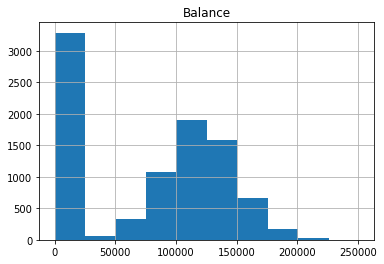

In [9]:
data.hist('Balance')
plt.show()

In [10]:
zero_balance = data.query('Balance == 0')
print('Клиенты, имеющие нулевой баланс:', len(zero_balance))
zero_balance.head()

Клиенты, имеющие нулевой баланс: 3283


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.0,1,1,1,101348.88,1
3,4,15701354,Boni,699,France,Female,39,1,0.0,2,0,0,93826.63,0
6,7,15592531,Bartlett,822,France,Male,50,7,0.0,2,1,1,10062.80,0
11,12,15737173,Andrews,497,Spain,Male,24,3,0.0,2,1,0,76390.01,0
12,13,15632264,Kay,476,France,Female,34,10,0.0,2,1,0,26260.98,0


Более 3000 клиентов банка имеют нулевой баланс. Ситуация может быть правдоподобной, особенно если банк предоставляет бесплатное обслуживание.

Построим боксплот предполагаемой зарплаты:

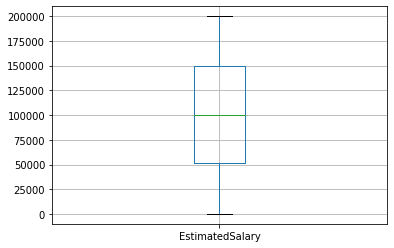

In [11]:
data.boxplot('EstimatedSalary')
plt.show()

Первый квартиль находится на уровне €50 000, в то время как нижний ус почти лежит на нулевой границе.

### Вывод

Файл представлен 14 признаками, из которых 3 нам не понадобятся для обучения модели: RowNumber (индекс строки в данных), CustomerId (уникальный идентификатор), Surname (фамилия клиента).

- Exited - будет целевым признаком. Построенная модель будет предсказывать значение 1 если клиент уйдет или 0 если клиент останется. В этом заключается наша задача классификации, т.к. целевой признак является категориальным;

- Нулевой баланс более 3000 клиентов банка может претендовать на истину, но в реальных условиях обязательно нужно уточнить этот момент;

- Большая разница между самой высокой предполагаемой зарплатой и низкой тоже может быть реалистичной, т.к. в наше время некоторые имеют пассивный доход. Но, как и в случае с нулевым балансом, этот момент тоже нужно уточнить: заполняет этот признак клиент или его предсказывает другая модель.

### Подготовка выборки для дальнейшего обучения моделей

In [12]:
len(data.query('EstimatedSalary < 20_000'))

909

Удалим ненужные признаки:

In [13]:
features_ignored = ['RowNumber', 'CustomerId', 'Surname']
data = data.drop(features_ignored, axis=1)

Зафиксируем псевдослучайность для всех используемых в проекте алгоритмов:

In [14]:
rnd_state = 47

Создадим несколько функций, которые помогут нам избежать дублирование кода:

In [15]:
def tf(data, target_column='Exited'):
    '''Функция возвращает целевой признак и признаки для обучения модели.'''    
    target = data[target_column]
    features = data.drop(target_column, axis=1)
    return target, features

Разобьем набор данных на обучающую (60%), валидационную(20%) и тестовую(20%) выборки. Затем проведем масштабирование признаков:

In [16]:
def split_data(features, target):
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.4, random_state=rnd_state
    )

    features_valid, features_test, target_valid, target_test = train_test_split(
        features_valid, target_valid, test_size=0.5, random_state=rnd_state
    )
    
    scaler = StandardScaler()
    numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
    scaler.fit(features_train[numeric])
    
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    features_test[numeric] = scaler.transform(features_test[numeric])
    
    return features_train, features_valid, features_test, target_train, target_valid, target_test

Создадим функцию, которая возвращает обученную модель:

In [17]:
def train_and_predict(data, model, log_prefix='', samplefunc=None, test=False):
    target, features = tf(data)
    features_train, features_valid, features_test, target_train, target_valid, target_test = split_data(features, target)
    
    if samplefunc:
        features_train, target_train = samplefunc(features_train, target_train)
    
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print(f'{log_prefix}F1-мера на валидационной выборке: {f1_score(target_valid, predicted_valid)}')
    
    if test:
        predictions_test = model.predict(features_test)
        print(f'{log_prefix}F1-мера на тестовой выборке: {f1_score(target_test, predicted_test)}')
    
    return model

## Исследование задачи

Посмотрим, насколько часто встречается класс «1» или «0» в целевом признаке:

0    0.796062
1    0.203938
Name: Exited, dtype: float64


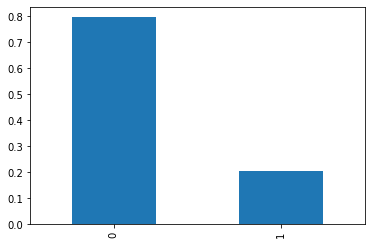

In [18]:
class_frequency = data['Exited'].value_counts(normalize=True)
class_frequency.plot(kind='bar')
print(class_frequency)
plt.show()

- Классы несбалансированы: всего 20% положительных и 80% отрицательных;
- На этом этапе мы проведем исследование модели без учета дисбаланса классов и будем ожидать заведомо плохие результаты;
- Часть признаков из файла категориальные. Для логистической регрессии нам необходимо сделать преобразование категориальных признаков прямым кодированием. Для алгоритмов решающего дерева или случайного леса необходимо сделать порядковое кодирование.



### Логистическая регрессия

In [19]:
data_ohe = pd.get_dummies(data, drop_first=True)

In [20]:
model = LogisticRegression(solver='liblinear', random_state=rnd_state)
train_and_predict(data_ohe, model)

F1-мера на валидационной выборке: 0.3441295546558704


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=47, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Логистическая регрессия показывает плохие результаты при дисбалансе классов.

Воспользуемся техникой порядкового кодирования для категориальных признаков:

In [21]:
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(data), columns=data.columns)

### Дерево решений

In [22]:
for max_depth in range(2, 22, 2):
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=rnd_state)
    train_and_predict(data_ordinal, model, log_prefix=f'max_depth {max_depth}:\t')

max_depth 2:	F1-мера на валидационной выборке: 0.535073409461664
max_depth 4:	F1-мера на валидационной выборке: 0.5543478260869564
max_depth 6:	F1-мера на валидационной выборке: 0.5512104283054003
max_depth 8:	F1-мера на валидационной выборке: 0.5633802816901408
max_depth 10:	F1-мера на валидационной выборке: 0.5559105431309903
max_depth 12:	F1-мера на валидационной выборке: 0.5393939393939394
max_depth 14:	F1-мера на валидационной выборке: 0.5196629213483146
max_depth 16:	F1-мера на валидационной выборке: 0.5286713286713286
max_depth 18:	F1-мера на валидационной выборке: 0.509641873278237
max_depth 20:	F1-мера на валидационной выборке: 0.5013774104683195


С глубиной равной 10, мы получили результат 0.5421133231240429. Далее посмотрим работу модели случайного леса.

### Случайный лес

In [23]:
import warnings
warnings.simplefilter('ignore')

In [24]:
for max_depth in range(2, 22, 2):
    model = RandomForestClassifier(max_depth=max_depth, random_state=rnd_state)
    train_and_predict(data_ordinal, model, log_prefix=f'max_depth {max_depth}:\t')

max_depth 2:	F1-мера на валидационной выборке: 0.24499999999999997
max_depth 4:	F1-мера на валидационной выборке: 0.2696078431372549
max_depth 6:	F1-мера на валидационной выборке: 0.5489443378119002
max_depth 8:	F1-мера на валидационной выборке: 0.5547169811320756
max_depth 10:	F1-мера на валидационной выборке: 0.5601436265709157
max_depth 12:	F1-мера на валидационной выборке: 0.5457809694793537
max_depth 14:	F1-мера на валидационной выборке: 0.5747899159663865
max_depth 16:	F1-мера на валидационной выборке: 0.5860927152317881
max_depth 18:	F1-мера на валидационной выборке: 0.5608465608465609
max_depth 20:	F1-мера на валидационной выборке: 0.5694444444444444


In [25]:
for estim in range(10, 201, 10):
    model = RandomForestClassifier(n_estimators=estim, max_depth=16, random_state=rnd_state)
    train_and_predict(data_ordinal, model, log_prefix=f'n_estimators = {estim}:\t')

n_estimators = 10:	F1-мера на валидационной выборке: 0.5860927152317881
n_estimators = 20:	F1-мера на валидационной выборке: 0.5892255892255893
n_estimators = 30:	F1-мера на валидационной выборке: 0.5836177474402731
n_estimators = 40:	F1-мера на валидационной выборке: 0.5868055555555555
n_estimators = 50:	F1-мера на валидационной выборке: 0.6010362694300518
n_estimators = 60:	F1-мера на валидационной выборке: 0.5993031358885017
n_estimators = 70:	F1-мера на валидационной выборке: 0.5944055944055944
n_estimators = 80:	F1-мера на валидационной выборке: 0.604895104895105
n_estimators = 90:	F1-мера на валидационной выборке: 0.6006944444444445
n_estimators = 100:	F1-мера на валидационной выборке: 0.6031195840554593
n_estimators = 110:	F1-мера на валидационной выборке: 0.602076124567474
n_estimators = 120:	F1-мера на валидационной выборке: 0.6038394415357766
n_estimators = 130:	F1-мера на валидационной выборке: 0.6031195840554593
n_estimators = 140:	F1-мера на валидационной выборке: 0.603119

<a class="anchor" id="21-bullet">

In [45]:
def train_and_predict_1(data, model, log_prefix='', samplefunc=None, test=False):
    target, features = tf(data)
    features_train, features_valid, features_test, target_train, target_valid, target_test = split_data(features, target)
    
    if samplefunc:
        features_train, target_train = samplefunc(features_train, target_train)
    
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    #print(f'{log_prefix}F1-мера на валидационной выборке: {f1_score(target_valid, predicted_valid)}')
    
    if test:
        predictions_test = model.predict(features_test)
        #print(f'{log_prefix}F1-мера на тестовой выборке: {f1_score(target_test, predicted_test)}')
    
    return model, f1_score(target_valid, predicted_valid)

In [42]:
from tqdm.notebook import tqdm

In [47]:
best_score = 0
best_depth = 0
best_n_estim = 0
best_model = None

for max_depth in tqdm(range(2, 22, 2), desc='Depth loop:'):
    for estim in tqdm(range(10, 201, 10), desc='Estim loop:', leave=False):
        model = RandomForestClassifier(max_depth=max_depth, n_estimators=estim, random_state=rnd_state)
        m, f1 = train_and_predict_1(data_ordinal, model, log_prefix=f'max_depth {max_depth}:\t')
        if f1 > best_score:
            best_score = f1
            best_depth = m.get_params('max_depth')
            best_n_estim = m.get_params('n_estimators')
            best_model = m

max_depth 2:	F1-мера на валидационной выборке: 0.24499999999999997
max_depth 2:	F1-мера на валидационной выборке: 0.21079691516709512
max_depth 2:	F1-мера на валидационной выборке: 0.20618556701030927
max_depth 2:	F1-мера на валидационной выборке: 0.20155038759689925
max_depth 2:	F1-мера на валидационной выборке: 0.12903225806451613
max_depth 2:	F1-мера на валидационной выборке: 0.10869565217391304
max_depth 2:	F1-мера на валидационной выборке: 0.12903225806451613
max_depth 2:	F1-мера на валидационной выборке: 0.12903225806451613
max_depth 2:	F1-мера на валидационной выборке: 0.144
max_depth 2:	F1-мера на валидационной выборке: 0.14893617021276595
max_depth 2:	F1-мера на валидационной выборке: 0.15384615384615385
max_depth 2:	F1-мера на валидационной выборке: 0.15873015873015872
max_depth 2:	F1-мера на валидационной выборке: 0.15873015873015872
max_depth 2:	F1-мера на валидационной выборке: 0.15384615384615385
max_depth 2:	F1-мера на валидационной выборке: 0.15873015873015872
max_depth

max_depth 4:	F1-мера на валидационной выборке: 0.2696078431372549
max_depth 4:	F1-мера на валидационной выборке: 0.27737226277372257
max_depth 4:	F1-мера на валидационной выборке: 0.34272300469483563
max_depth 4:	F1-мера на валидационной выборке: 0.36194895591647336
max_depth 4:	F1-мера на валидационной выборке: 0.3559718969555035
max_depth 4:	F1-мера на валидационной выборке: 0.40091116173120733
max_depth 4:	F1-мера на валидационной выборке: 0.4170403587443946
max_depth 4:	F1-мера на валидационной выборке: 0.4144144144144144
max_depth 4:	F1-мера на валидационной выборке: 0.4507658643326039
max_depth 4:	F1-мера на валидационной выборке: 0.4668094218415418
max_depth 4:	F1-мера на валидационной выборке: 0.44638949671772427
max_depth 4:	F1-мера на валидационной выборке: 0.43668122270742366
max_depth 4:	F1-мера на валидационной выборке: 0.4351648351648352
max_depth 4:	F1-мера на валидационной выборке: 0.44008714596949894
max_depth 4:	F1-мера на валидационной выборке: 0.4468546637744034
max

max_depth 6:	F1-мера на валидационной выборке: 0.5489443378119002
max_depth 6:	F1-мера на валидационной выборке: 0.5497076023391813
max_depth 6:	F1-мера на валидационной выборке: 0.558766859344894
max_depth 6:	F1-мера на валидационной выборке: 0.5627376425855513
max_depth 6:	F1-мера на валидационной выборке: 0.5549132947976879
max_depth 6:	F1-мера на валидационной выборке: 0.55893536121673
max_depth 6:	F1-мера на валидационной выборке: 0.5610687022900763
max_depth 6:	F1-мера на валидационной выборке: 0.5616698292220113
max_depth 6:	F1-мера на валидационной выборке: 0.5557655954631381
max_depth 6:	F1-мера на валидационной выборке: 0.5595463137996219
max_depth 6:	F1-мера на валидационной выборке: 0.5551330798479087
max_depth 6:	F1-мера на валидационной выборке: 0.5523809523809524
max_depth 6:	F1-мера на валидационной выборке: 0.5496183206106869
max_depth 6:	F1-мера на валидационной выборке: 0.5496183206106869
max_depth 6:	F1-мера на валидационной выборке: 0.5485714285714286
max_depth 6:	

max_depth 8:	F1-мера на валидационной выборке: 0.5547169811320756
max_depth 8:	F1-мера на валидационной выборке: 0.5698324022346368
max_depth 8:	F1-мера на валидационной выборке: 0.5814814814814814
max_depth 8:	F1-мера на валидационной выборке: 0.5851851851851853
max_depth 8:	F1-мера на валидационной выборке: 0.582089552238806
max_depth 8:	F1-мера на валидационной выборке: 0.5831775700934579
max_depth 8:	F1-мера на валидационной выборке: 0.585820895522388
max_depth 8:	F1-мера на валидационной выборке: 0.5847299813780261
max_depth 8:	F1-мера на валидационной выборке: 0.582089552238806
max_depth 8:	F1-мера на валидационной выборке: 0.5825602968460111
max_depth 8:	F1-мера на валидационной выборке: 0.5836431226765798
max_depth 8:	F1-мера на валидационной выборке: 0.5836431226765798
max_depth 8:	F1-мера на валидационной выборке: 0.5851851851851853
max_depth 8:	F1-мера на валидационной выборке: 0.5825602968460111
max_depth 8:	F1-мера на валидационной выборке: 0.5825602968460111
max_depth 8:	

max_depth 10:	F1-мера на валидационной выборке: 0.5601436265709157
max_depth 10:	F1-мера на валидационной выборке: 0.5842293906810037
max_depth 10:	F1-мера на валидационной выборке: 0.5806451612903226
max_depth 10:	F1-мера на валидационной выборке: 0.5867620751341682
max_depth 10:	F1-мера на валидационной выборке: 0.5863309352517986
max_depth 10:	F1-мера на валидационной выборке: 0.5869565217391304
max_depth 10:	F1-мера на валидационной выборке: 0.5890909090909091
max_depth 10:	F1-мера на валидационной выборке: 0.5833333333333333
max_depth 10:	F1-мера на валидационной выборке: 0.5916515426497277
max_depth 10:	F1-мера на валидационной выборке: 0.595667870036101
max_depth 10:	F1-мера на валидационной выборке: 0.5905797101449275
max_depth 10:	F1-мера на валидационной выборке: 0.588021778584392
max_depth 10:	F1-мера на валидационной выборке: 0.588021778584392
max_depth 10:	F1-мера на валидационной выборке: 0.5833333333333333
max_depth 10:	F1-мера на валидационной выборке: 0.585895117540687

max_depth 12:	F1-мера на валидационной выборке: 0.5457809694793537
max_depth 12:	F1-мера на валидационной выборке: 0.5886524822695035
max_depth 12:	F1-мера на валидационной выборке: 0.5911504424778761
max_depth 12:	F1-мера на валидационной выборке: 0.590339892665474
max_depth 12:	F1-мера на валидационной выборке: 0.590339892665474
max_depth 12:	F1-мера на валидационной выборке: 0.590990990990991
max_depth 12:	F1-мера на валидационной выборке: 0.5960502692998205
max_depth 12:	F1-мера на валидационной выборке: 0.5943060498220641
max_depth 12:	F1-мера на валидационной выборке: 0.5982300884955752
max_depth 12:	F1-мера на валидационной выборке: 0.5921985815602837
max_depth 12:	F1-мера на валидационной выборке: 0.5932504440497336
max_depth 12:	F1-мера на валидационной выборке: 0.5957446808510638
max_depth 12:	F1-мера на валидационной выборке: 0.6003552397868561
max_depth 12:	F1-мера на валидационной выборке: 0.599290780141844
max_depth 12:	F1-мера на валидационной выборке: 0.599290780141844


max_depth 14:	F1-мера на валидационной выборке: 0.5747899159663865
max_depth 14:	F1-мера на валидационной выборке: 0.579861111111111
max_depth 14:	F1-мера на валидационной выборке: 0.5827586206896551
max_depth 14:	F1-мера на валидационной выборке: 0.5799648506151143
max_depth 14:	F1-мера на валидационной выборке: 0.5834797891036906
max_depth 14:	F1-мера на валидационной выборке: 0.5890652557319224
max_depth 14:	F1-мера на валидационной выборке: 0.5957446808510638
max_depth 14:	F1-мера на валидационной выборке: 0.5905096660808435
max_depth 14:	F1-мера на валидационной выборке: 0.597173144876325
max_depth 14:	F1-мера на валидационной выборке: 0.5896980461811724
max_depth 14:	F1-мера на валидационной выборке: 0.5901060070671379
max_depth 14:	F1-мера на валидационной выборке: 0.5964912280701754
max_depth 14:	F1-мера на валидационной выборке: 0.6010544815465729
max_depth 14:	F1-мера на валидационной выборке: 0.5975395430579965
max_depth 14:	F1-мера на валидационной выборке: 0.59964726631393

max_depth 16:	F1-мера на валидационной выборке: 0.5860927152317881
max_depth 16:	F1-мера на валидационной выборке: 0.5892255892255893
max_depth 16:	F1-мера на валидационной выборке: 0.5836177474402731
max_depth 16:	F1-мера на валидационной выборке: 0.5868055555555555
max_depth 16:	F1-мера на валидационной выборке: 0.6010362694300518
max_depth 16:	F1-мера на валидационной выборке: 0.5993031358885017
max_depth 16:	F1-мера на валидационной выборке: 0.5944055944055944
max_depth 16:	F1-мера на валидационной выборке: 0.604895104895105
max_depth 16:	F1-мера на валидационной выборке: 0.6006944444444445
max_depth 16:	F1-мера на валидационной выборке: 0.6031195840554593
max_depth 16:	F1-мера на валидационной выборке: 0.602076124567474
max_depth 16:	F1-мера на валидационной выборке: 0.6038394415357766
max_depth 16:	F1-мера на валидационной выборке: 0.6031195840554593
max_depth 16:	F1-мера на валидационной выборке: 0.6031195840554593
max_depth 16:	F1-мера на валидационной выборке: 0.60489510489510

max_depth 18:	F1-мера на валидационной выборке: 0.5608465608465609
max_depth 18:	F1-мера на валидационной выборке: 0.5795053003533569
max_depth 18:	F1-мера на валидационной выборке: 0.5886402753872634
max_depth 18:	F1-мера на валидационной выборке: 0.5888501742160279
max_depth 18:	F1-мера на валидационной выборке: 0.5913043478260871
max_depth 18:	F1-мера на валидационной выборке: 0.6068965517241379
max_depth 18:	F1-мера на валидационной выборке: 0.6145833333333333
max_depth 18:	F1-мера на валидационной выборке: 0.6103448275862069
max_depth 18:	F1-мера на валидационной выборке: 0.6137931034482759
max_depth 18:	F1-мера на валидационной выборке: 0.607638888888889
max_depth 18:	F1-мера на валидационной выборке: 0.6041666666666667
max_depth 18:	F1-мера на валидационной выборке: 0.610051993067591
max_depth 18:	F1-мера на валидационной выборке: 0.6017391304347826
max_depth 18:	F1-мера на валидационной выборке: 0.6079447322970639
max_depth 18:	F1-мера на валидационной выборке: 0.60553633217993

max_depth 20:	F1-мера на валидационной выборке: 0.5694444444444444
max_depth 20:	F1-мера на валидационной выборке: 0.6010362694300518
max_depth 20:	F1-мера на валидационной выборке: 0.5937499999999999
max_depth 20:	F1-мера на валидационной выборке: 0.5989492119089317
max_depth 20:	F1-мера на валидационной выборке: 0.5898778359511343
max_depth 20:	F1-мера на валидационной выборке: 0.5958188153310103
max_depth 20:	F1-мера на валидационной выборке: 0.5993031358885017
max_depth 20:	F1-мера на валидационной выборке: 0.5979020979020979
max_depth 20:	F1-мера на валидационной выборке: 0.5996533795493935
max_depth 20:	F1-мера на валидационной выборке: 0.5972222222222222
max_depth 20:	F1-мера на валидационной выборке: 0.5993031358885017
max_depth 20:	F1-мера на валидационной выборке: 0.5958188153310103
max_depth 20:	F1-мера на валидационной выборке: 0.5923344947735192
max_depth 20:	F1-мера на валидационной выборке: 0.5954465849387041
max_depth 20:	F1-мера на валидационной выборке: 0.601739130434

In [49]:
best_score

0.6145833333333333

In [48]:
best_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=18, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=47, verbose=0,
                       warm_start=False)

Как можно заметить, метрика еще выше
<hr style="border: 2px solid orange;" />

## Борьба с дисбалансом

Возьмем во внимание дисбаланс классов. Посмотрим, как это повлияет на исследуемые модели.

### Взвешивание классов

Придадим объектам редкого класса 1 больший вес используя гиперпараметр class_weight='balanced'.

#### Логистическая регрессия

In [26]:
model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=rnd_state)
train_and_predict(data_ohe, model)

F1-мера на валидационной выборке: 0.4688995215311005


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=47, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Значение F1-меры увеличилось.

#### Дерево решений

In [27]:
for max_depth in range(2, 22, 2):
    model = DecisionTreeClassifier(class_weight='balanced', max_depth=max_depth, random_state=rnd_state)
    train_and_predict(data_ordinal, model, log_prefix=f'max_depth {max_depth}:\t')

max_depth 2:	F1-мера на валидационной выборке: 0.5137614678899083
max_depth 4:	F1-мера на валидационной выборке: 0.4892857142857143
max_depth 6:	F1-мера на валидационной выборке: 0.5469556243550052
max_depth 8:	F1-мера на валидационной выборке: 0.5334645669291338
max_depth 10:	F1-мера на валидационной выборке: 0.5118279569892473
max_depth 12:	F1-мера на валидационной выборке: 0.4994192799070848
max_depth 14:	F1-мера на валидационной выборке: 0.5037783375314862
max_depth 16:	F1-мера на валидационной выборке: 0.4974093264248704
max_depth 18:	F1-мера на валидационной выборке: 0.5013192612137203
max_depth 20:	F1-мера на валидационной выборке: 0.4939271255060729


Наилучший результат: 0.574370709382151 у решающего дерева с глубиной 6.

#### Случайный лес

In [28]:
for max_depth in range(2, 22, 2):
    model = RandomForestClassifier(class_weight='balanced', max_depth=max_depth, random_state=rnd_state)
    train_and_predict(data_ordinal, model, log_prefix=f'max_depth {max_depth}:\t')

max_depth 2:	F1-мера на валидационной выборке: 0.5569620253164558
max_depth 4:	F1-мера на валидационной выборке: 0.5533678756476683
max_depth 6:	F1-мера на валидационной выборке: 0.5827505827505828
max_depth 8:	F1-мера на валидационной выборке: 0.597051597051597
max_depth 10:	F1-мера на валидационной выборке: 0.6055776892430278
max_depth 12:	F1-мера на валидационной выборке: 0.5795795795795796
max_depth 14:	F1-мера на валидационной выборке: 0.5843071786310517
max_depth 16:	F1-мера на валидационной выборке: 0.549645390070922
max_depth 18:	F1-мера на валидационной выборке: 0.5557586837294334
max_depth 20:	F1-мера на валидационной выборке: 0.5297297297297296


Наилучший результат 0.6055776892430278 был показан при гиперпараметре глубины дерева 10.

In [29]:
for estim in range(10, 201, 10):
    model = RandomForestClassifier(class_weight='balanced', n_estimators=estim, max_depth=10, random_state=rnd_state)
    train_and_predict(data_ordinal, model, log_prefix=f'n_estimators = {estim}:\t')

n_estimators = 10:	F1-мера на валидационной выборке: 0.6055776892430278
n_estimators = 20:	F1-мера на валидационной выборке: 0.5983827493261455
n_estimators = 30:	F1-мера на валидационной выборке: 0.6113416320885201
n_estimators = 40:	F1-мера на валидационной выборке: 0.6199158485273492
n_estimators = 50:	F1-мера на валидационной выборке: 0.628491620111732
n_estimators = 60:	F1-мера на валидационной выборке: 0.625
n_estimators = 70:	F1-мера на валидационной выборке: 0.6225352112676057
n_estimators = 80:	F1-мера на валидационной выборке: 0.6318758815232722
n_estimators = 90:	F1-мера на валидационной выборке: 0.628005657708628
n_estimators = 100:	F1-мера на валидационной выборке: 0.6299435028248588
n_estimators = 110:	F1-мера на валидационной выборке: 0.6326241134751773
n_estimators = 120:	F1-мера на валидационной выборке: 0.6385372714486638
n_estimators = 130:	F1-мера на валидационной выборке: 0.6311360448807855
n_estimators = 140:	F1-мера на валидационной выборке: 0.6333808844507846
n_

А вот модель случайного леса показывает самое высокое значение F1-меры: 0.6385372714486638 при количестве деревьев равном 120.

### Увеличение выборки

Cделаем объекты редкого класса не такими редкими и переобучим модели.

In [30]:
def upsample(features, target, repeat=10):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=rnd_state)
    
    return features_upsampled, target_upsampled

#### Логистическая регрессия

In [31]:
model = LogisticRegression(solver='liblinear', random_state=rnd_state)
train_and_predict(data_ohe, model, samplefunc=upsample)

F1-мера на валидационной выборке: 0.39540507859733975


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=47, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

#### Дерево решений

In [32]:
for max_depth in range(2, 22, 2):
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=rnd_state)
    train_and_predict(data_ordinal, model, samplefunc=upsample, log_prefix=f'max_depth {max_depth}:\t')

max_depth 2:	F1-мера на валидационной выборке: 0.32132963988919666
max_depth 4:	F1-мера на валидационной выборке: 0.40200375704445845
max_depth 6:	F1-мера на валидационной выборке: 0.4765625
max_depth 8:	F1-мера на валидационной выборке: 0.46586345381526106
max_depth 10:	F1-мера на валидационной выборке: 0.5009310986964618
max_depth 12:	F1-мера на валидационной выборке: 0.503030303030303
max_depth 14:	F1-мера на валидационной выборке: 0.5206124852767963
max_depth 16:	F1-мера на валидационной выборке: 0.5240506329113925
max_depth 18:	F1-мера на валидационной выборке: 0.5132978723404257
max_depth 20:	F1-мера на валидационной выборке: 0.505586592178771


#### Случайный лес

In [33]:
for estim in range(10, 201, 10):
    model = RandomForestClassifier(n_estimators=estim, max_depth=10, random_state=rnd_state)
    train_and_predict(data_ordinal, model, samplefunc=upsample, log_prefix=f'n_estimators = {estim}:\t')

n_estimators = 10:	F1-мера на валидационной выборке: 0.5215004574565416
n_estimators = 20:	F1-мера на валидационной выборке: 0.5312499999999999
n_estimators = 30:	F1-мера на валидационной выборке: 0.5278538812785388
n_estimators = 40:	F1-мера на валидационной выборке: 0.528714676390155
n_estimators = 50:	F1-мера на валидационной выборке: 0.5283363802559415
n_estimators = 60:	F1-мера на валидационной выборке: 0.5302752293577983
n_estimators = 70:	F1-мера на валидационной выборке: 0.5354185832566698
n_estimators = 80:	F1-мера на валидационной выборке: 0.5351851851851852
n_estimators = 90:	F1-мера на валидационной выборке: 0.535681186283596
n_estimators = 100:	F1-мера на валидационной выборке: 0.5322283609576427
n_estimators = 110:	F1-мера на валидационной выборке: 0.5360443622920518
n_estimators = 120:	F1-мера на валидационной выборке: 0.5355493998153278
n_estimators = 130:	F1-мера на валидационной выборке: 0.5341959334565619
n_estimators = 140:	F1-мера на валидационной выборке: 0.533210

Значение F1-меры у каждой из рассмотренных моделей меньше, чем в случае балансировки классов.

### Уменьшение выборки

In [34]:
def downsample(features, target, fraction = 0.2):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=rnd_state)] + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=rnd_state)] + [target_ones]
    )
    
    return features_downsampled, target_downsampled

#### Логистическая регрессия

In [35]:
model = LogisticRegression(solver='liblinear', random_state=rnd_state)
train_and_predict(data_ohe, model, samplefunc=downsample)

F1-мера на валидационной выборке: 0.46457990115321257


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=47, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

#### Дерево решений

In [36]:
for max_depth in range(2, 22, 2):
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=rnd_state)
    train_and_predict(data_ordinal, model, samplefunc=downsample, log_prefix=f'max_depth {max_depth}:\t')

max_depth 2:	F1-мера на валидационной выборке: 0.5137614678899083
max_depth 4:	F1-мера на валидационной выборке: 0.46725949878738887
max_depth 6:	F1-мера на валидационной выборке: 0.5250683682771194
max_depth 8:	F1-мера на валидационной выборке: 0.4949402023919043
max_depth 10:	F1-мера на валидационной выборке: 0.46975088967971534
max_depth 12:	F1-мера на валидационной выборке: 0.4650751547303272
max_depth 14:	F1-мера на валидационной выборке: 0.4574468085106383
max_depth 16:	F1-мера на валидационной выборке: 0.45166959578207383
max_depth 18:	F1-мера на валидационной выборке: 0.43700440528634354
max_depth 20:	F1-мера на валидационной выборке: 0.43700440528634354


#### Случайный лес

In [37]:
for estim in range(10, 201, 10):
    model = RandomForestClassifier(n_estimators=estim, max_depth=10, random_state=rnd_state)
    train_and_predict(data_ordinal, model, samplefunc=downsample, log_prefix=f'n_estimators = {estim}:\t')

n_estimators = 10:	F1-мера на валидационной выборке: 0.5136612021857924
n_estimators = 20:	F1-мера на валидационной выборке: 0.5103324348607368
n_estimators = 30:	F1-мера на валидационной выборке: 0.5223744292237443
n_estimators = 40:	F1-мера на валидационной выборке: 0.52
n_estimators = 50:	F1-мера на валидационной выборке: 0.5319926873857403
n_estimators = 60:	F1-мера на валидационной выборке: 0.5345622119815668
n_estimators = 70:	F1-мера на валидационной выборке: 0.5393883225208527
n_estimators = 80:	F1-мера на валидационной выборке: 0.5387453874538745
n_estimators = 90:	F1-мера на валидационной выборке: 0.5349264705882353
n_estimators = 100:	F1-мера на валидационной выборке: 0.5337026777469992
n_estimators = 110:	F1-мера на валидационной выборке: 0.5392428439519852
n_estimators = 120:	F1-мера на валидационной выборке: 0.5350553505535055
n_estimators = 130:	F1-мера на валидационной выборке: 0.5349264705882353
n_estimators = 140:	F1-мера на валидационной выборке: 0.53690036900369
n_e

Значение F1-меры у каждой из рассмотренных моделей меньше, чем в случае балансировки классов.

## Тестирование модели

Исходя из наших манипуляций с моделями делаем вывод, что наилучшей моделью оказался случайный лес с количеством деревьев 120 и глубиной 10 с учетом балансировки классов.

Протестируем:

In [38]:
target, features = tf(data_ordinal)
features_train, features_valid, features_test, target_train, target_valid, target_test = split_data(features, target)

model = RandomForestClassifier(class_weight='balanced', n_estimators=120, max_depth=10, random_state=rnd_state)
model.fit(features_train, target_train)

#predicted_valid = model.predict(features_valid)
#print('valid:', f1_score(target_valid, predicted_valid))

predicted_test = model.predict(features_test)
print('test:', f1_score(target_test, predicted_test))

test: 0.6024423337856173


<div style="border:solid red 2px; padding: 20px"> <b>Что необходимо доработать</b><br>
Для тестирования модели можно выбрать один из двух вариантов:<br>
<ul>
    <li> Обучать на train, подбор гиперпараметров по оценка на valid, результирующее тестирование на test
    <li> Обучать на train, подбор гиперпараметров по оценка на valid, выбранная лучшая модель обучается на train+valid и тестируется на test</ul><br>
Наша задача очень проста, использовать как можно больше данных для обучения модели, в таком случае модель получится более лучшей\стабильной и вторая задача учиться. Поэтому давай попробуем с тобой второй способ тестирования модели</div> <br>

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Исправлено:</b> Объединил выборки, результат оказался чуть-чуть лучше..</div>

<div style="border:solid green 2px; padding: 20px"> <b>Отличная работа 2</b><br>👍Если модель хорошо обобщает данные, то чем больше данных, тем лучше модель (не всегда на много, но лучше)</div> 

# Попробуем обучить модель на обобщенной выборке и посмотрим, улучшит ли это результат

In [39]:
target, features = tf(data_ordinal)
features_train, features_valid, features_test, target_train, target_valid, target_test = split_data(features, target)
X_trainvalid = pd.concat([features_train, features_valid])
y_trainvalid = pd.concat([target_train, target_valid])
model = RandomForestClassifier(class_weight='balanced', n_estimators=120, max_depth=10, random_state=rnd_state)
model.fit(X_trainvalid, y_trainvalid)
#predicted_valid = model.predict(features_valid)
#print('valid:', f1_score(target_valid, predicted_valid))
predicted_test = model.predict(features_test)
print('test:', f1_score(target_test, predicted_test))

test: 0.6097560975609756


Посчитаем AUC-ROC для нашей модели и посмотрим насколько она лучше случайной модели:

In [40]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

roc_auc_score(target_valid, probabilities_one_valid)

0.966746813667996

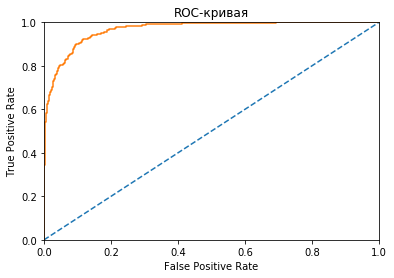

In [41]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 
plt.figure()
#ROC-кривая случайной модели (выглядит как прямая):
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
#Применим функции plt.xlim() и plt.ylim(), чтобы установить границы осей от 0 до 1:
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
#Применим функции plt.xlabel() и plt.ylabel(), чтобы 
#подписать оси "False Positive Rate" и "True Positive Rate":
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Добавим к графику заголовок "ROC-кривая" функцией plt.title():
plt.title('ROC-кривая')
plt.show() 


Наша метрика выше AUC-ROC случайной модели и стремится к единице.

### Вывод
В ходе построения модели, которая делает прогноз уйдет ли клиент из банка или нет, было сделано следующее:

- Не влияющие на построение модели признаки были удалены;
- На этапе обработки данных было проведено масштабирование признаков и кодирование категориальных данных;
- На основе наших экспериментов с моделями сделали вывод, что лучшей моделью является случайный лес с количеством деревьев равным 100 и глубиной равной 8 с учетом балансировки классов;
- Наша метрика выше AUC-ROC случайной модели и стремится к единице.

<hr style="border: 2px solid green;" />

## Общий комментарий
Спасибо за проделанную работу🤝

Дмитрий, проект выполнен хорошо, есть две доработки:
- корректно подобрать гиперпараметры для случайного леса
- использовать 2 способ тестирования модели

Исправляй и отправляй на проверку🛠

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*